# Machine Learning Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsOneClassifier
from sklearn.calibration import CalibratedClassifierCV
from category_encoders.binary import BinaryEncoder
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import lightgbm as lbg
from catboost import CatBoostClassifier
import joblib
import warnings

**binary encoding for categorical feature having cardinality greater than 3**

In [2]:
target_1_impfeatures = set(['num_symptoms','genes_in_mother_side','inherited_from_father','maternal_gene','paternal_gene','blood_cell_count','avg_parents_age','FE_2','white_blood_cell_count','patient_age','institute_name','num_symptoms','blood_test_result'])
target_2_impfeatures = set(['blood_cell_count','avg_parents_age','white_blood_cell_count','FE_2','institute_name','patient_age','num_symptoms','genes_in_mother_side','inherited_from_father','maternal_gene','paternal_gene'])

In [3]:
important_features = set(['target_1','target_2'])
important_features=important_features.union(target_1_impfeatures.union(target_2_impfeatures))

In [4]:
important_features

{'FE_2',
 'avg_parents_age',
 'blood_cell_count',
 'blood_test_result',
 'genes_in_mother_side',
 'inherited_from_father',
 'institute_name',
 'maternal_gene',
 'num_symptoms',
 'paternal_gene',
 'patient_age',
 'target_1',
 'target_2',
 'white_blood_cell_count'}

# Useful functions

In [4]:
def cross_validate(x_train,y_train,params,clf,cv_type):
    """Function to perform cross validationo and returns cross validate object
    Parameters:
    -----------
    x_train - array of all transformed features  
    y-train - array of all target variables
    params  - hyperparameters to which model needs to be tuned
    clf     - classifier or regressor on which hyperparameter needs to be performed
    cv_type - type of cross validation eg., "grid" - GridSearchCV / "random" - RandomSearchCV
    
    Return:
    -------
    grdcv - fitted cross validation object
    """
    params = params
    clf = clf
    if cv_type == 'grid':
        grdcv = GridSearchCV(clf,params,cv=3,scoring='f1_macro',return_train_score=True,verbose=3)
        grdcv.fit(x_train,y_train)
        return grdcv
    elif cv_type == 'random':
        grdcv = RandomizedSearchCV(clf,param_distributions=params,cv=3,scoring='f1_macro',return_train_score=True,verbose=3)
        grdcv.fit(x_train,y_train)
        return grdcv

In [5]:
# Reference: Code taken from Applied AI Real World Case study Quora Question pair Similarity Problem
def plot_confusion_matrix(test_y, predict_y,num_classes):
    """ Function to plot confusion matrix, precision matrix and recall matrix by taking inputs as y_test and y_predicted"""
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(30,4))
    
    labels = [i for i in range(num_classes)]
 
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap='binary', fmt=".3f")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap='binary', fmt=".3f")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap='binary', fmt=".3f")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [6]:
class ResponseEncoder():
    '''Class for Response Encoding of the categorical features
    
    Parameters:
    -----------
       x - Categorical feature
       y - target class of the dataset     
       
    '''
    
    def __init__(self,x=None,y=None):
        self.x = x
        self.y = y
        self.cat_dict={}
        self.final = {}
        self.unq_target = None
        self.unq_cat = None
        self.combined = None
        
    def get_classes(self,y=None):
        """
        Function to return all the unique target classes in y
        
        Parameters :
        ------------
        y - array 
            Target variable of the dataset
        
        Returns:
        --------
        np.sort(np.unique(y))- unique array of classes in target variable
        """
        return np.sort(np.unique(y))
    
    
    def get_categories(self,x=None):
        """
        Function to return all the unique categories in the categorical feature passed
        
        Parameters :
        ------------
        x - array 
             feature that needs to be encoded
             
        Returns:
        --------
        np.unique(x) - unique array of categories
        """
        return np.unique(x)
    
    
    def combine_array(self,x=None,y=None):
        """
        Function to combine the target variable and the categorical feature
        
        Parameters:
        -----------
        x - array 
             feature that needs to be encoded
        y - array 
            Target variable of the dataset
        
        Returns:
        --------
        np.hstack((x.reshape(-1,1),y.reshape(-1,1))) - 2D array of target and feature combined
        """
        return np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
    
    
        
    def fit(self,x,y=None):
        """
        Function to calculate probabilty of particular category found in each class of the target variable in the form of n-class length array
        
        Parameters:
        -----------
        x - array 
             feature that needs to be encoded
        y - array 
            Target variable of the dataset
        
        Returns:
        --------
        self - Object
               fitted encoder     
        
        Example:
        --------
          test_= np.asarray([['A',0],['B',1],['C',1],['B',0],['C',0],['A',1],['B',1],['C',1],['C',0],['A',0],['B',1],['C',1],['B',0],['C',0]])
          test = ResponseEncoder()
          test.fit(test_[:,0],test_[:,1])
        """
        self.unq_target = self.get_classes(y)
        self.unq_cat = self.get_categories(x)
        self.combined = self.combine_array(x,y)    
        for i in self.unq_cat:
            self.cat_dict[i] = self.combined[np.where(self.combined[:,0]==i)]
        
        for i in self.unq_cat:
            temp_list = []
            temp = self.cat_dict[i]
            
            for j in self.unq_target:
                temp_list.append(len(temp[np.where(temp[:,1]==j)])+1)
                
            temp_list = np.asarray(temp_list)
            denom = sum(temp_list)
            self.final[i]=(np.round(temp_list/(denom),2))
        return self
    
    
    
    
    def transform(self,x):
        """
        Function to replace the category with array which is length of n_classes in target and corresponding probability of the category in the particular class
        
        Parameters:
        -----------
        x - array 
             feature that needs to be encoded
        
        Returns:
        --------
        transformed - array of shape (rows_of_x,no_of_unique_target _classes)     
        
        Example:
        --------
          test_= np.asarray([['A',0],['B',1],['C',1],['B',0],['C',0],['A',1],['B',1],['C',1],['C',0],['A',0],['B',1],['C',1],['B',0],['C',0]])
          test = ResponseEncoder()
          test.fit(test_[:,0],test_[:,1])
          test.transform(test_[:,0])
          
          output:
          ------
        array([[0.6 , 0.4 ],
               [0.43, 0.57],
               [0.5 , 0.5 ],
               [0.43, 0.57],
               [0.5 , 0.5 ],
               [0.6 , 0.4 ],
               [0.43, 0.57],
               [0.5 , 0.5 ],
               [0.5 , 0.5 ],
               [0.6 , 0.4 ],
               [0.43, 0.57],
               [0.5 , 0.5 ],
               [0.43, 0.57],
               [0.5 , 0.5 ]])
        """
        result=[]
        for i in range(len(x)):
            if x[i] in self.unq_cat:
                result.append(self.final[x[i]])
        transformed = np.asarray(result)
        return transformed
        

In [7]:
def model(x_train,y_train,x_test,y_test,clf,params,cv_type):
    
    """ 
    Parameters:
    -----------
    x_train - prre processed training data
    y_train - target of training data
    x_test  - pre processed testing data
    y_test  - target of testing data
    clf     - classifier on which cv needs to be performed
    params  - parameters for cross validdation
    cv_type - type of cross validation 'grid'/'random'
    
    Output:
    -------
    results - It is dictionary will all the results from cross validation and also the predictions
    from best model from cross validation on training and test data
    """
    
    results={}
    results['cv_result'] = cross_validate(x_train,y_train,params,clf,cv_type)
    
    results['best_estimator'] = results['cv_result'].best_estimator_
    results['best_estimator'].fit(x_train,y_train)
    
    results['model'] = CalibratedClassifierCV(results['best_estimator'],method='sigmoid')
    results['model'].fit(x_train,y_train)
       
    results['y_test_pred'] = results['model'].predict(x_test)
    results['y_test_pred_proba'] = results['model'].predict_proba(x_test)
    
    results['y_train_pred'] = results['model'].predict(x_train)
    results['y_train_pred_proba'] = results['model'].predict_proba(x_train)
    
    results['f1_score'] = f1_score(y_test,results['y_test_pred'],average='macro')
    results['log_loss'] = log_loss(y_test,results['y_test_pred_proba'])
    
    return results    

In [8]:
def data_splitting(x,target,test_size):
    """Function to split the data into training and testing sets. Takes a dataframe as input,test_size and target variable name, outputs train and test data"""
    X = x.drop(target,axis=1)
    y = x[target]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,stratify=y,random_state=42)
    
    return X_train,X_test,y_train,y_test    

In [9]:
def effective_f1score(target_1,target_2):
    "function to calculate the effective f1_score for predicting target-1 and target-2"
    # Genetic Disorder
    score1 = max(0, 100*target_1)

    # Disorder Subclass
    score2 = max(0, 100*target_2)

    # Final score
    score = (score1/2)+(score2/2)
    return score

In [10]:
def numerical_transformations(x):
    '''This function takes x dataframe as input and fits standard scaler 
    on the numerical data returns list of standard scaler objects for each feature'''
    scaler_list = []
    cols = x.columns
    for i in cols:
        scaler =  StandardScaler()
        scaler.fit(x[i].values.reshape(-1,1))
        scaler_list.append(scaler)
    return scaler_list

In [11]:
def one_hot_encoding(x):
    """ This function takes array of categorical features as input, fits and returns one hot encoding object of that feature """
    vectorizer = OneHotEncoder(sparse=False)
    vectorizer.fit(x.reshape(-1,1))
    return vectorizer

In [12]:
def Response_encoding(x,y):
    """ This function takes array of categorical features as input, fits and returns Response encoding object of that feature """
    enc = ResponseEncoder()
    enc.fit(x,y)
    return enc

In [13]:
warnings.filterwarnings("ignore")

In [14]:
#Loading Imputed Train Dataset
df_train = pd.read_csv('Data/imputed_train.csv',usecols=important_features)
# df_train.drop('Unnamed: 0',axis=1,inplace=True)
df_train.head()

,patient_age,blood_cell_count,white_blood_cell_count,num_symptoms,genes_in_mother_side,inherited_from_father,maternal_gene,paternal_gene,institute_name,blood_test_result,FE_2,avg_parents_age,target_1,target_2
0,2.0,4.760603,9.857562,5.0,Yes,No,Yes,No,boston_specialty_rehabilitation_hospital,abnormal,0.438460,42.925,0,5
1,6.0,4.893297,3.535653,4.0,Yes,No,No,No,new_england_baptist_hospital,normal,1.078852,31.500,1,3
2,12.0,4.705280,7.919321,1.0,Yes,No,Yes,No,franciscan_children_hospital,inconclusive,0.527538,29.400,0,6
3,11.0,4.720703,4.098210,0.0,Yes,No,Yes,Yes,carney_hospital,normal,0.925953,41.250,1,1
4,14.0,5.103188,10.272230,2.0,Yes,No,Yes,No,massachusetts_general_hospital,normal,0.452722,37.400,2,2


In [15]:
df_test = pd.read_csv('Data/imputed_test.csv')
# df_test.drop('Unnamed: 0',axis=1,inplace=True)
df_test.head()

,Patient Id,patient_age,blood_cell_count,white_blood_cell_count,num_symptoms,genes_in_mother_side,inherited_from_father,maternal_gene,paternal_gene,institute_name,...,serious_maternal_illness,radiation_exposure,substance_abuse,assisted_conception,history_of_anomalies_in_previous_pregnancies,birth_defects,blood_test_result,FE_1,FE_2,avg_parents_age
0,PID0x4175,6,4.981655,8.637817,5,No,Yes,No,No,st_elizabeth_hospital,...,No,Yes,Yes,No,Yes,Multiple,slightly abnormal,1.666667,0.516886,49.5
1,PID0x21f5,10,5.118890,8.179584,1,Yes,No,Yes,Yes,not_applicable,...,No,Yes,Not applicable,No,Yes,Multiple,normal,0.307692,0.557639,43.0
2,PID0x49b8,5,4.876204,7.614210,2,No,Yes,No,No,va_hospital,...,Yes,Yes,Yes,Yes,No,Singular,slightly abnormal,2.000000,0.566065,54.0
3,PID0x2d97,13,4.687767,6.884071,3,No,Yes,Yes,No,boston_specialty_rehabilitation_hospital,...,Yes,Yes,Not applicable,Yes,Yes,Singular,normal,0.967742,0.594587,40.0
4,PID0x58da,5,5.152362,6.195178,4,No,No,No,Yes,not_applicable,...,Yes,Yes,Not applicable,No,No,Multiple,normal,1.777778,0.716085,39.5


In [16]:
# getting all the numercial columns excluding target variables
numerical_cols = [i for i in df_train.select_dtypes(include=['float64','int64']).columns if i != 'target_1' or i!='target_2']

# Data Splitting

In [17]:
X_train,X_test,y_train,y_test = data_splitting(df_train,['target_1','target_2'],0.2)

In [18]:
# Resetting the index of X_train,X_test,y_train,y_test
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [19]:
print('Train set')
print(X_train.shape)
print(X_test.shape)
print('\nTest set')
print(y_train.shape)
print(y_test.shape)

Train set
(13452, 12)
(3364, 12)

Test set
(13452, 2)
(3364, 2)


# Data Transformation

##### 2.5.3 All features Response encoding

In [20]:
res_enc_dict_target_2 = {}
for i in X_train.select_dtypes(include=['object']).columns:
    if X_train[i].nunique()>=3 and i in important_features:
        res_enc_dict_target_2[i] = Response_encoding(X_train[i].values,y_train.values[:,1])

In [21]:
X_train_tar2_categorical = pd.DataFrame(index=X_train.index)
X_test_tar2_categorical = pd.DataFrame(index=X_test.index)

In [22]:
classes = np.sort(np.unique(y_train['target_2']))

In [23]:
# In this code we will transform the data using the response encoding objects in enc_dict

#Iterating through all the categorical features in train data
for i in X_train.select_dtypes(include=['object']).columns:
    if X_train[i].nunique()>=3 and i in important_features :
        #creating column names 'gender'->'gender_class_1','gender_class_2'
        columns = [i+'_tar2class_'+str(j) for j in classes]

        # storing transformed features into a temporary dataframe temp_train and temp_train
        temp_train = pd.DataFrame(res_enc_dict_target_2[i].transform(X_train[i].values),columns=columns)
        temp_test = pd.DataFrame(res_enc_dict_target_2[i].transform(X_test[i].values),columns=columns)

        # Concatenating all the features generated in an iteration with Feature_set2_train and Feature_set2_test
        X_train_tar2_categorical = pd.concat([X_train_tar2_categorical, temp_train], axis=1) 
        X_test_tar2_categorical = pd.concat([X_test_tar2_categorical, temp_test], axis=1) 

In [24]:
# the two lists are used for storing all the features whose cardinality is equal to 2 and cardinality is mmore than 2
cardinality_eq_two,cardinality_gt_two = [],[]
for i in X_train.select_dtypes(include=['object']).columns:
    if X_train[i].nunique()==2:
        cardinality_eq_two.append(i)
    elif X_train[i].nunique()>2:
        cardinality_gt_two.append(i)

In [25]:
numerical_cols = [i for i in numerical_cols if i not in ['target_1','target_2']]

In [26]:
# initializing different encoders for categorical features and standard scaler for numerical features
one_hot_encoder = OneHotEncoder(sparse=False)
binary_encoder = BinaryEncoder(cols=cardinality_gt_two)
standard_scaler = StandardScaler()

In [27]:
# creating columns for one hot encoded features
one_hot_cols=[]
for i in cardinality_eq_two:
    for j in X_train[i].unique():
        one_hot_cols.append(str(i)+'_'+str(j))

In [28]:
binary_cols=['blood_test_result_0', 'blood_test_result_1', 'blood_test_result_2']

In [29]:
# new_cols are all the columns for pre processed data in dataframe
new_df_cols = one_hot_cols+binary_cols+numerical_cols

In [30]:
new_df_cols

['genes_in_mother_side_Yes',
 'genes_in_mother_side_No',
 'inherited_from_father_No',
 'inherited_from_father_Yes',
 'maternal_gene_Yes',
 'maternal_gene_No',
 'paternal_gene_No',
 'paternal_gene_Yes',
 'blood_test_result_0',
 'blood_test_result_1',
 'blood_test_result_2',
 'patient_age',
 'blood_cell_count',
 'white_blood_cell_count',
 'num_symptoms',
 'FE_2',
 'avg_parents_age']

##### Numerical Features + Categorical Features with cardinality = 2 encoded with One Hot Encoding + Categorical Features with cardinality > 2 encoded with Binary Encoding 

In [31]:
pre_processor_1 = ColumnTransformer([
    ('one-hot-encoder', one_hot_encoder, cardinality_eq_two),
    ('binary_encoder', binary_encoder, cardinality_gt_two),
    ('standard_scaler', standard_scaler, numerical_cols)])
pre_processor_1.fit(X_train)

ColumnTransformer(transformers=[('one-hot-encoder', OneHotEncoder(sparse=False),
                                 ['genes_in_mother_side',
                                  'inherited_from_father', 'maternal_gene',
                                  'paternal_gene']),
                                ('binary_encoder',
                                 BinaryEncoder(cols=['institute_name',
                                                     'blood_test_result']),
                                 ['institute_name', 'blood_test_result']),
                                ('standard_scaler', StandardScaler(),
                                 ['patient_age', 'blood_cell_count',
                                  'white_blood_cell_count', 'num_symptoms',
                                  'FE_2', 'avg_parents_age'])])

In [32]:
# train and test data transformed with pre_processor_1
FS_1_train = pd.DataFrame(pre_processor_1.transform(X_train),columns=new_df_cols)
FS_1_test = pd.DataFrame(pre_processor_1.transform(X_test),columns=new_df_cols)

##### Numerical Features + Categorical Features with cardinality = 2 encoded with One Hot Encoding + Categorical Features with cardinality > 2 encoded with Response Encoding taking target_1 as variable

In [33]:
pre_processor_2 = ColumnTransformer([
    ('one-hot-encoder', one_hot_encoder, cardinality_eq_two),
    ('standard_scaler', standard_scaler, numerical_cols)])
pre_processor_2.fit(X_train)

ColumnTransformer(transformers=[('one-hot-encoder', OneHotEncoder(sparse=False),
                                 ['genes_in_mother_side',
                                  'inherited_from_father', 'maternal_gene',
                                  'paternal_gene']),
                                ('standard_scaler', StandardScaler(),
                                 ['patient_age', 'blood_cell_count',
                                  'white_blood_cell_count', 'num_symptoms',
                                  'FE_2', 'avg_parents_age'])])

In [34]:
cols_ = one_hot_cols+numerical_cols

In [35]:
FS_2_train = pd.DataFrame(pre_processor_2.transform(X_train),columns=cols_)
FS_2_test = pd.DataFrame(pre_processor_2.transform(X_test),columns=cols_)

In [36]:
# train and test data transformed with pre_processor_2
FS_2_train = pd.concat([FS_2_train,X_train_tar2_categorical],axis=1)
FS_2_test = pd.concat([FS_2_test,X_test_tar2_categorical],axis=1)

# Upsampling

In [56]:
# upsampling training data with SMOTENC which is used to handle numerical as well as categorical data
Upsample1 = SMOTENC(categorical_features=[0,15])
Upsample2 = SMOTENC(categorical_features=[0,7])

In [57]:
X_tr1,y_tr1 = Upsample1.fit_resample(pd.concat([FS_1_train,y_train['target_1']],axis=1),y_train.values[:,1])
X_tr2,y_tr2 = Upsample2.fit_resample(pd.concat([FS_2_train,y_train['target_1']],axis=1),y_train.values[:,1])

In [58]:
label_FS1 = X_tr1.target_1
label_FS2 = X_tr2.target_1
X_tr1.drop('target_1',axis=1,inplace=True)
X_tr2.drop('target_1',axis=1,inplace=True) 

* FS_1_train - Feature training set pre processed with pre_processor_1
* FS_1_test  - Feature testing set pre processed with pre_processor_1
* FS_2_train - Feature training set pre processed with pre_processor_2
* FS_2_test  - Feature testing set pre processed with pre_processor_2
* X_tr1      - Upsampled FS_1_train    
* y_tr1      - Upsampled y_train
* X_tr2      - Upsampled FS_2_train 
* y_tr2      - Upsampled y_train
* label_FS1  - Upsampled target_1 using Upsample1
* label_FS2  - Upsampled target_1 using Upsample2 

**Note :** Here I have performed upsampling of target_2 as y_train so I have considered target_1 inside X_train and stored the upsampled target-1 in label_FS1 and label_FS2. 

**Modeling approach :**
* Cross validation on the model for finding best classifier for predicting target_2
* using the predicted target_2 and probabilities from the model is used to train another model for predicting target_1
* Evaluation of both the models
  *  **Genetic Disorder(target-1)**  : score1 = max(0, 100*metrics.f1_score(actual["Genetic Disorder"], predicted["Genetic Disorder"], average="macro"))
  *  **Disorder Subclass(target-2)** : score2 = max(0, 100*metrics.f1_score(actual["Disorder Subclass"], predicted["Disorder Subclass"], average="macro"))
  *  **Final score** : score = (score1/2)+(score2/2)
  
The above approach is followed for training all the model

# Logistic Regression

In [51]:
params = {'estimator__alpha' : [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10] }

##### Feature Set-1 for predicting target_2

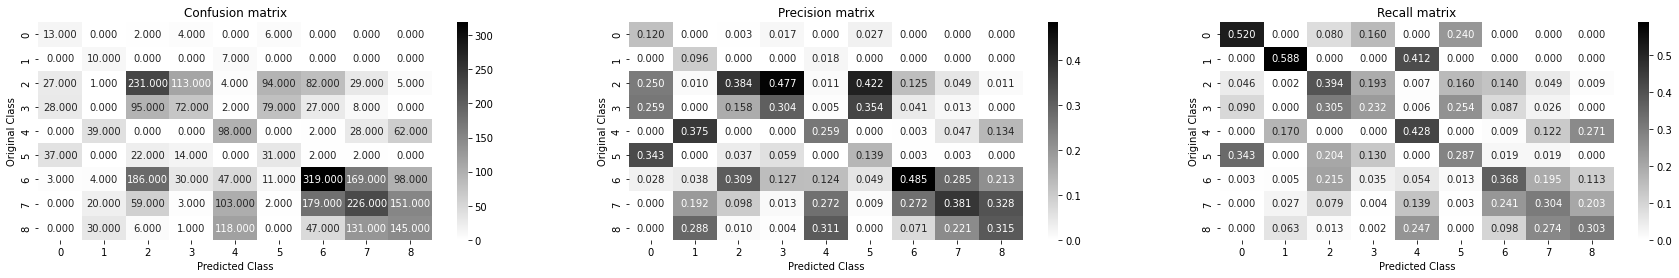

f1_score : 0.2875523346451197
log_loss : 1.5467993973128242


In [54]:
# LR_clf_tar2 = OneVsOneClassifier(SGDClassifier(loss='log'))
# LR_fs1_tar2 = model(X_tr1,y_tr1,FS_1_test,y_test.values[:,1],LR_clf_tar2,params,cv_type="grid")
LR_fs1_tar2 = joblib.load('Models/LR_fs1_tar2.pkl')
plot_confusion_matrix(y_test.values[:,1], LR_fs1_tar2['y_test_pred'],9)

print("f1_score :" ,LR_fs1_tar2['f1_score'])
print("log_loss :" ,LR_fs1_tar2['log_loss'])

In [59]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

# proba_2_train and proba_2_test are two dataframes which store prediction probabilities and target variables from the best classifier.
proba2_train = pd.DataFrame(np.concatenate((LR_fs1_tar2['y_train_pred_proba'],LR_fs1_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((LR_fs1_tar2['y_test_pred_proba'],LR_fs1_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
#appending prediction probabilities and targets of target_2 on training and testing data to predict target_1 
tar_1_X_train = pd.concat([X_tr1,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_1_test,proba2_test],axis=1)

##### Feature Set-1 for predicting target_1

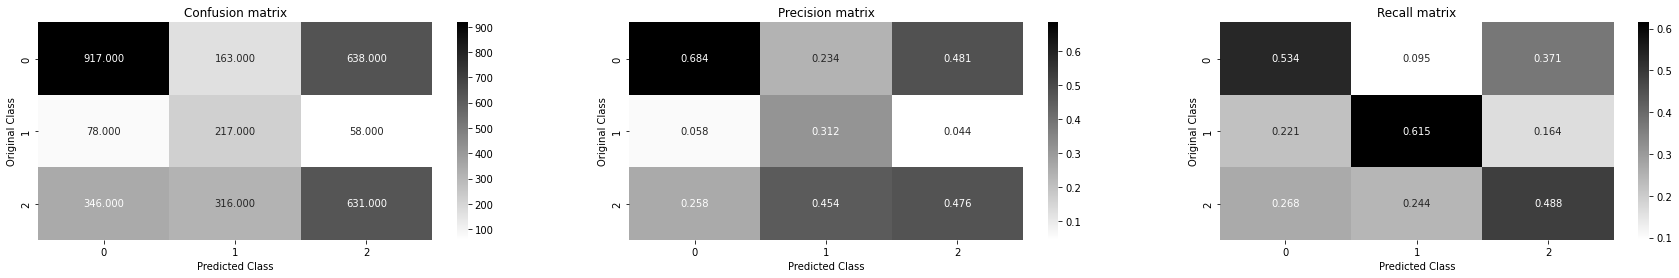

f1_score : 0.498316360932994
log_loss : 0.9287242759229433


In [60]:
# LR_clf_tar1 = OneVsOneClassifier(SGDClassifier(loss='log'))
# LR_fs1_tar1 = model(tar_1_X_train,label_FS1,tar_1_X_test,y_test.values[:,0],LR_clf_tar1,params,cv_type="grid")
LR_fs1_tar1 = joblib.load('Models/LR_fs1_tar1.pkl')
plot_confusion_matrix(y_test.values[:,0], LR_fs1_tar1['y_test_pred'],3)

print("f1_score :" ,LR_fs1_tar1['f1_score'])
print("log_loss :" ,LR_fs1_tar1['log_loss'])

In [61]:
effective_f1score(LR_fs1_tar1['f1_score'],LR_fs1_tar2['f1_score'])

39.293434778905684

In [90]:
# filename = 'Models/LR_fs1_tar2.pkl'
# joblib.dump(LR_fs1_tar2,open(filename,'wb'))

# filename = 'Models/LR_fs1_tar1.pkl'
# joblib.dump(LR_fs1_tar1,open(filename,'wb'))

##### Feature Set-2 for predicting target_2

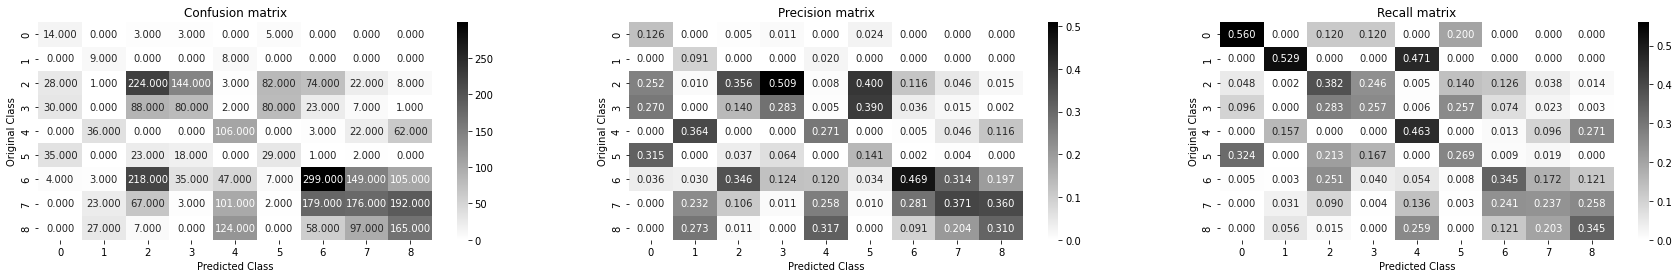

f1_score : 0.2821210359406281
log_loss : 1.5375659852663768


In [62]:
# LR_clf_tar2 = OneVsOneClassifier(SGDClassifier(loss='log'))
# LR_fs2_tar2 = model(X_tr2,y_tr2,FS_2_test,y_test.values[:,1],LR_clf_tar2,params,cv_type="grid")
LR_fs2_tar2 = joblib.load('Models/LR_fs2_tar2.pkl')

plot_confusion_matrix(y_test.values[:,1], LR_fs2_tar2['y_test_pred'],9)

print("f1_score :" ,LR_fs2_tar2['f1_score'])
print("log_loss :" ,LR_fs2_tar2['log_loss'])

In [48]:
# cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((LR_fs2_tar2['y_train_pred_proba'],LR_fs2_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((LR_fs2_tar2['y_test_pred_proba'],LR_fs2_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr2,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_2_test,proba2_test],axis=1)

##### Feature Set-2 for predicting target_1

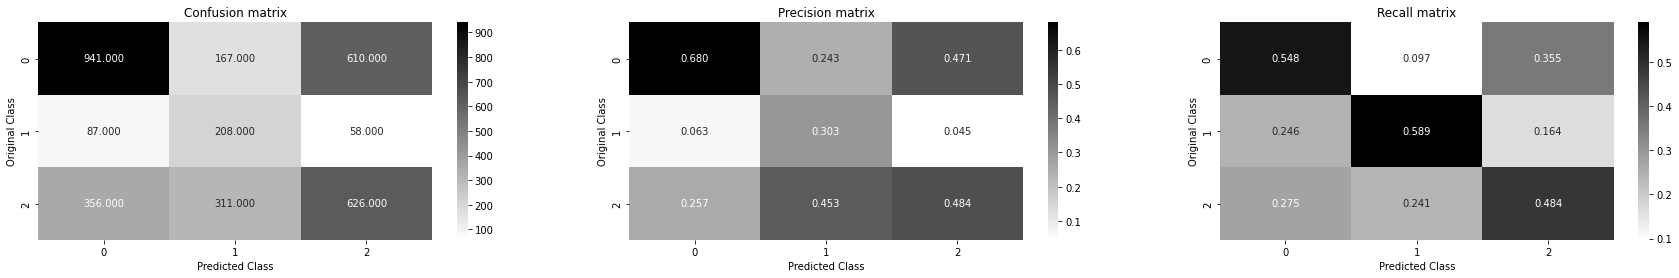

f1_score : 0.49701619658390594
log_loss : 0.9281171469707881


In [63]:
# LR_clf_tar1 = OneVsOneClassifier(SGDClassifier(loss='log'))
# LR_fs2_tar1 = model(tar_1_X_train,label_FS2,tar_1_X_test,y_test.values[:,0],LR_clf_tar1,params,cv_type="grid")
LR_fs2_tar1 = joblib.load('Models/LR_fs2_tar1.pkl')
plot_confusion_matrix(y_test.values[:,0], LR_fs2_tar1['y_test_pred'],3)

print("f1_score :" ,LR_fs2_tar1['f1_score'])
print("log_loss :" ,LR_fs2_tar1['log_loss'])

In [64]:
effective_f1score(LR_fs2_tar1['f1_score'],LR_fs2_tar2['f1_score'])

38.956861626226704

In [95]:
# filename = 'Models/LR_fs2_tar2.pkl'
# joblib.dump(LR_fs1_tar2,open(filename,'wb'))

# filename = 'Models/LR_fs2_tar1.pkl'
# joblib.dump(LR_fs1_tar1,open(filename,'wb'))

# Kernel SVM

In [96]:
params = {'C' : [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10],'gamma':[0.0001,0.001,0.01,0.1]}

##### Feature Set-1 for predicting target_2

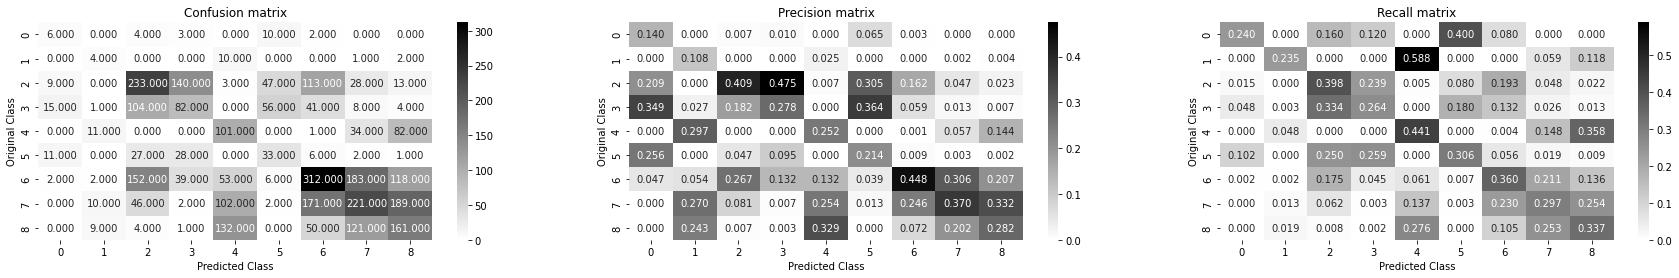

f1_score : 0.2896658033509479
log_loss : 1.5899353999988852


In [97]:
# svm_clf = SVC(kernel='rbf')
# svm_fs1_tar2 = model(X_tr1,y_tr1,FS_1_test,y_test.values[:,1],svm_clf,params,cv_type="random")
svm_fs1_tar2 = joblib.load('Models/RBFsvm_fs1_tar2.pkl')

plot_confusion_matrix(y_test.values[:,1], svm_fs1_tar2['y_test_pred'],9)

print("f1_score :" ,svm_fs1_tar2['f1_score'])
print("log_loss :" ,svm_fs1_tar2['log_loss'])

In [98]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((svm_fs1_tar2['y_train_pred_proba'],svm_fs1_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((svm_fs1_tar2['y_test_pred_proba'],svm_fs1_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr1,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_1_test,proba2_test],axis=1)

##### Feature Set-1 for predicting target_1

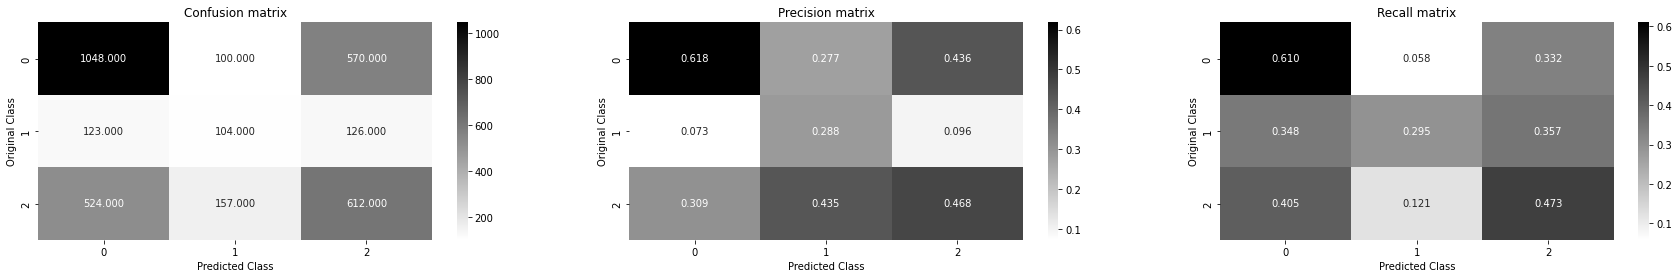

f1_score : 0.4586757449341687
log_loss : 1.0371195242405382


In [99]:
# svm_clf = SVC(kernel='rbf')
# svm_fs1_tar1 = model(tar_1_X_train,label_FS1,tar_1_X_test,y_test.values[:,0],svm_clf,params,cv_type="random")
svm_fs1_tar1 = joblib.load('Models/RBFsvm_fs1_tar1.pkl')

plot_confusion_matrix(y_test.values[:,0], svm_fs1_tar1['y_test_pred'],3)

print("f1_score :" ,svm_fs1_tar1['f1_score'])
print("log_loss :" ,svm_fs1_tar1['log_loss'])

In [100]:
# filename = 'Models/RBFsvm_fs1_tar2.pkl'
# joblib.dump(svm_fs1_tar2,open(filename,'wb'))

# filename = 'Models/RBFsvm_fs1_tar1.pkl'
# joblib.dump(svm_fs1_tar1,open(filename,'wb'))

In [101]:
effective_f1score(svm_fs1_tar1['f1_score'],svm_fs1_tar2['f1_score'])

37.41707741425583

##### Feature Set-2 for predicting target_2

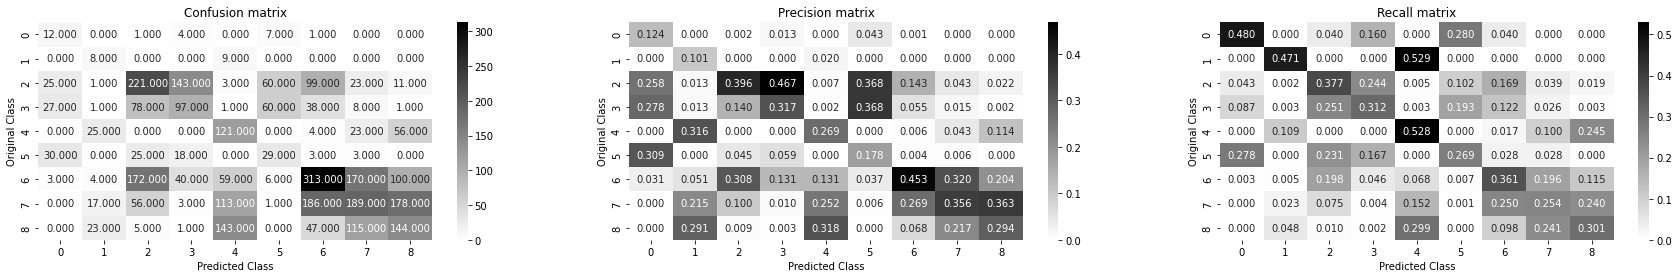

f1_score : 0.29235018635316834
log_loss : 1.526703719482404


In [102]:
# svm_clf = SVC(kernel='rbf')
# svm_fs2_tar2 = model(X_tr2,y_tr2,FS_2_test,y_test.values[:,1],svm_clf,params,cv_type="random")
svm_fs2_tar2 = joblib.load('Models/RBFsvm_fs2_tar2.pkl')
plot_confusion_matrix(y_test.values[:,1], svm_fs2_tar2['y_test_pred'],9)

print("f1_score :" ,svm_fs2_tar2['f1_score'])
print("log_loss :" ,svm_fs2_tar2['log_loss'])

In [103]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((svm_fs2_tar2['y_train_pred_proba'],svm_fs2_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((svm_fs2_tar2['y_test_pred_proba'],svm_fs2_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr2,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_2_test,proba2_test],axis=1)

##### Feature Set-2 for predicting target_1

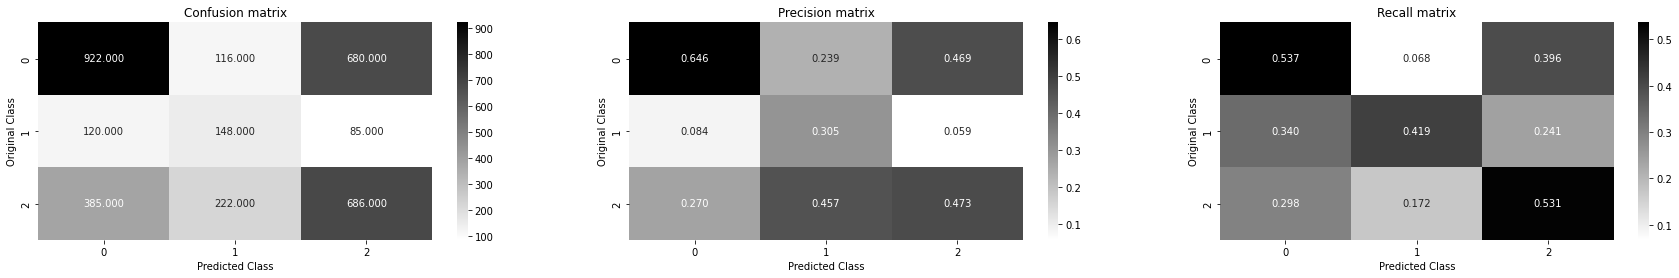

f1_score : 0.4797094858302178
log_loss : 0.9111661541860465


In [104]:
# svm_clf = SVC(kernel='rbf')
# svm_fs2_tar1 = model(tar_1_X_train,label_FS2,tar_1_X_test,y_test.values[:,0],svm_clf,params,cv_type="random")
svm_fs2_tar1 = joblib.load('Models/RBFsvm_fs2_tar1.pkl')
plot_confusion_matrix(y_test.values[:,0], svm_fs2_tar1['y_test_pred'],3)

print("f1_score :" ,svm_fs2_tar1['f1_score'])
print("log_loss :" ,svm_fs2_tar1['log_loss'])

In [105]:
# filename = 'Models/RBFsvm_fs2_tar2.pkl'
# joblib.dump(svm_fs2_tar2,open(filename,'wb'))

# filename = 'Models/RBFsvm_fs2_tar1.pkl'
# joblib.dump(svm_fs2_tar1,open(filename,'wb'))

In [106]:
effective_f1score(svm_fs2_tar1['f1_score'],svm_fs2_tar2['f1_score'])

38.60298360916931

# RandomForest

In [107]:
params = {'n_estimators' : [1000,2000,3000],'min_samples_split' : [2, 5, 10],'min_samples_leaf' : [1, 2, 4]}

##### Feature Set-1 for predicting target_2

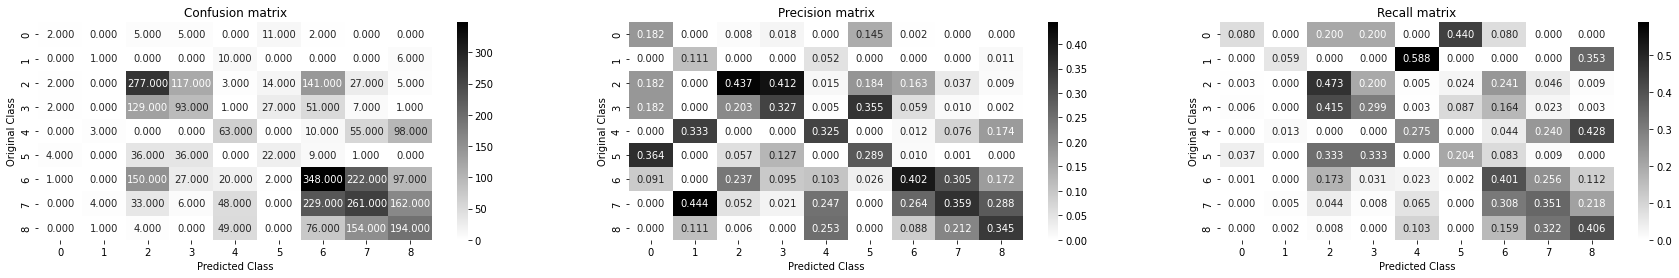

f1_score : 0.2912418491025264
log_loss : 1.5420811720180452


In [62]:
# rf_clf = RandomForestClassifier(warm_start=True)
# rf_fs1_tar2 = model(X_tr1,y_tr1,FS_1_test,y_test.values[:,1],rf_clf,params,cv_type="random")
rf_fs1_tar2 = joblib.load('Models/RF_fs1_tar2.pkl')

plot_confusion_matrix(y_test.values[:,1], rf_fs1_tar2['y_test_pred'],9)

print("f1_score :" ,rf_fs1_tar2['f1_score'])
print("log_loss :" ,rf_fs1_tar2['log_loss'])

In [63]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((rf_fs1_tar2['y_train_pred_proba'],rf_fs1_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((rf_fs1_tar2['y_test_pred_proba'],rf_fs1_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr1,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_1_test,proba2_test],axis=1)

##### Feature Set-1 for predicting target_1

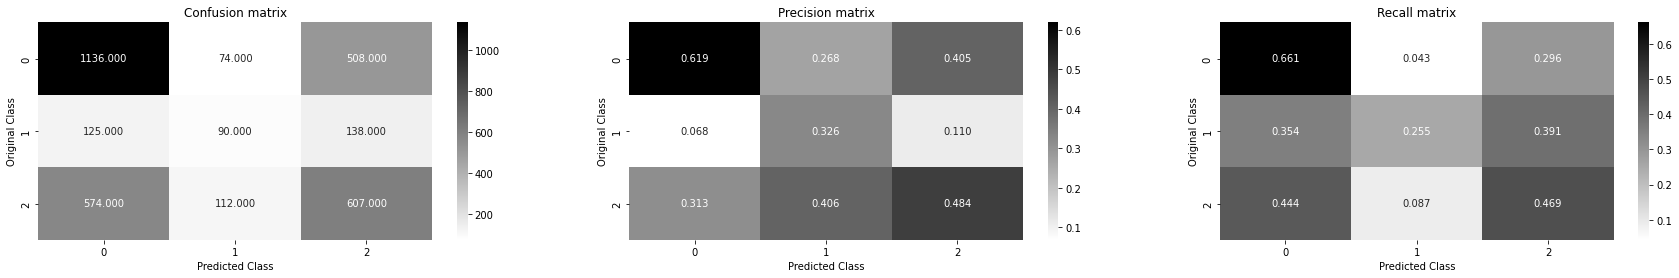

f1_score : 0.46748484246751426
log_loss : 1.5570730397742654


In [64]:
# rf_clf = RandomForestClassifier()
# rf_fs1_tar1 = model(tar_1_X_train,label_FS1,tar_1_X_test,y_test.values[:,0],rf_clf,params,cv_type="random")
rf_fs1_tar1 = joblib.load('Models/RF_fs1_tar1.pkl')
plot_confusion_matrix(y_test.values[:,0], rf_fs1_tar1['y_test_pred'],3)

print("f1_score :" ,rf_fs1_tar1['f1_score'])
print("log_loss :" ,rf_fs1_tar1['log_loss'])

In [65]:
# filename = 'Models/RF_fs1_tar2.pkl'
# joblib.dump(rf_fs1_tar2,open(filename,'wb'))

# filename = 'Models/RF_fs1_tar1.pkl'
# joblib.dump(rf_fs1_tar1,open(filename,'wb'))

In [66]:
effective_f1score(rf_fs1_tar1['f1_score'],rf_fs1_tar2['f1_score'])

37.93633457850203

##### Feature Set-2 for predicting target_2

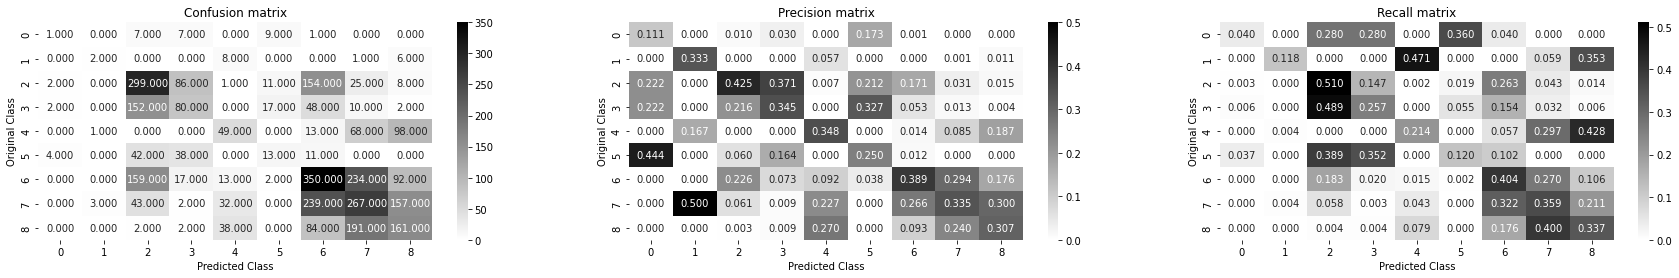

f1_score : 0.275868237982473
log_loss : 1.5421805015870924


In [67]:
# rf_clf = RandomForestClassifier()
# rf_fs2_tar2 = model(X_tr2,y_tr2,FS_2_test,y_test.values[:,1],rf_clf,params,cv_type="random")
rf_fs2_tar2 = joblib.load('Models/RF_fs2_tar2.pkl','r+')
plot_confusion_matrix(y_test.values[:,1], rf_fs2_tar2['y_test_pred'],9)

print("f1_score :" ,rf_fs2_tar2['f1_score'])
print("log_loss :" ,rf_fs2_tar2['log_loss'])

In [68]:
# filename = 'Models/RF_fs2_tar2.pkl'
# joblib.dump(rf_fs2_tar2,open(filename,'wb'))

In [69]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((rf_fs2_tar2['y_train_pred_proba'],rf_fs2_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((rf_fs2_tar2['y_test_pred_proba'],rf_fs2_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr2,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_2_test,proba2_test],axis=1)

##### Feature Set-2 for predicting target_1

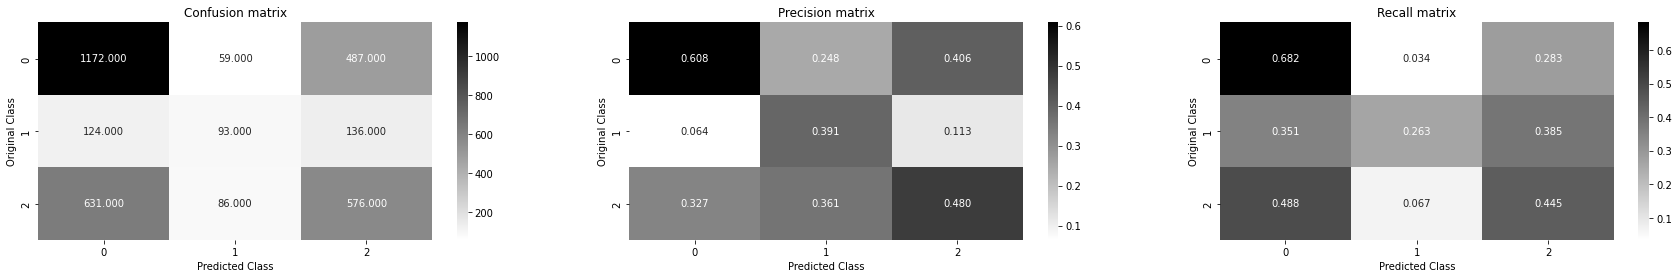

f1_score : 0.47335760275155686
log_loss : 1.5509585891390523


In [70]:
# rf_clf = RandomForestClassifier()
# rf_fs2_tar1 = model(tar_1_X_train,label_FS2,tar_1_X_test,y_test.values[:,0],rf_clf,params,cv_type="random")
rf_fs2_tar1 = joblib.load('Models/RF_fs2_tar1.pkl','r+')
plot_confusion_matrix(y_test.values[:,0], rf_fs2_tar1['y_test_pred'],3)

print("f1_score :" ,rf_fs2_tar1['f1_score'])
print("log_loss :" ,rf_fs2_tar1['log_loss'])

In [71]:
# filename = 'Models/RF_fs2_tar1.pkl'
# joblib.dump(rf_fs2_tar1,open(filename,'wb'))

In [72]:
effective_f1score(rf_fs2_tar1['f1_score'],rf_fs2_tar2['f1_score'])

37.461292036701494

# XGBoost

In [73]:
params ={
    
    'learning_rate':[0.0001, 0.001, 0.01, 0.1],
    'n_estimators':[1000,2000,3000],
   'max_depth' :[ 10,15,25],
   'min_data_in_leaf':[15,25],    
}

##### Feature Set-1 for predicting target_2

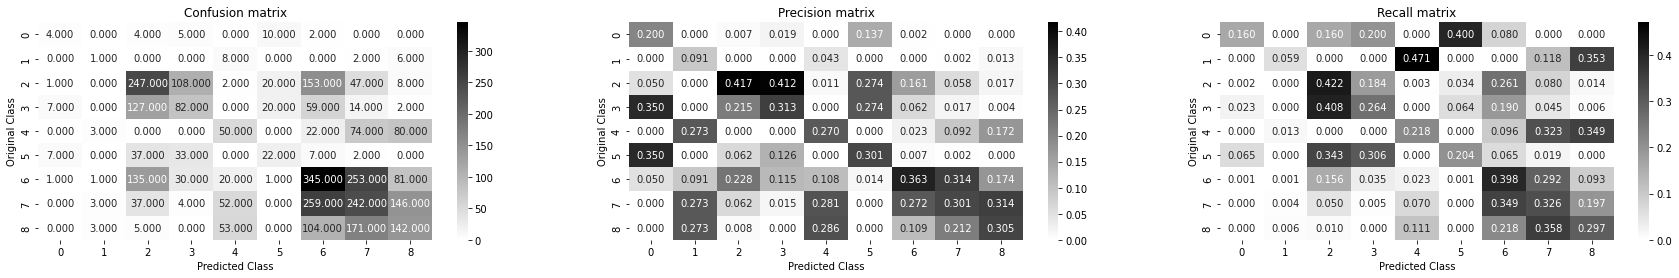

f1_score : 0.270308873466899
log_loss : 1.7823655360828612


In [74]:
# lgbm_clf = lbg.LGBMClassifier()
# lbgm_fs1_tar2 = model(X_tr1,y_tr1,FS_1_test,y_test.values[:,1],lgbm_clf,params,cv_type="random")
lbgm_fs1_tar2 = joblib.load('Models/lbgm_fs1_tar2.pkl','r+')

plot_confusion_matrix(y_test.values[:,1], lbgm_fs1_tar2['y_test_pred'],9)

print("f1_score :" ,lbgm_fs1_tar2['f1_score'])
print("log_loss :" ,lbgm_fs1_tar2['log_loss'])

In [75]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((lbgm_fs1_tar2['y_train_pred_proba'],lbgm_fs1_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((lbgm_fs1_tar2['y_test_pred_proba'],lbgm_fs1_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr1,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_1_test,proba2_test],axis=1)

In [76]:
# filename = 'Models/lbgm_fs1_tar2.pkl'
# joblib.dump(lbgm_fs1_tar2,open(filename,'wb'))

##### Feature Set-1 for predicting target_1

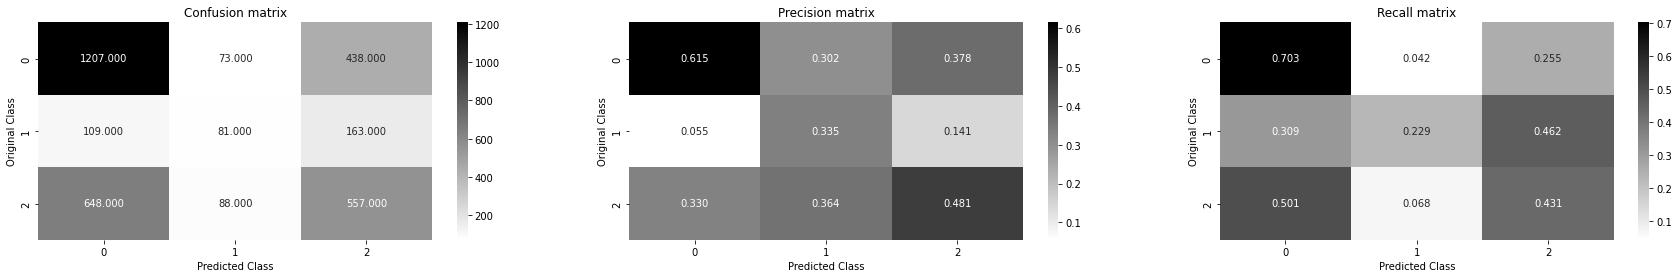

f1_score : 0.46079973869714747
log_loss : 2.1779389471378385


In [77]:
# lbgm_clf = lbg.LGBMClassifier(n_jobs=8)
# lbgm_fs1_tar1 = model(tar_1_X_train,label_FS1,tar_1_X_test,y_test.values[:,0],lbgm_clf,params,cv_type="random")
lbgm_fs1_tar1 = joblib.load('Models/lbgm_fs1_tar1.pkl','r+')

plot_confusion_matrix(y_test.values[:,0], lbgm_fs1_tar1['y_test_pred'],3)

print("f1_score :" ,lbgm_fs1_tar1['f1_score'])
print("log_loss :" ,lbgm_fs1_tar1['log_loss'])

In [78]:
# filename = 'Models/lbgm_fs1_tar1.pkl'
# joblib.dump(lbgm_fs1_tar1,open(filename,'wb'))

In [79]:
effective_f1score(lbgm_fs1_tar1['f1_score'],lbgm_fs1_tar2['f1_score'])

36.55543060820233

##### Feature Set-2 for predicting target_2

In [80]:
# lgbm_clf = lbg.LGBMClassifier(n_jobs=8)
# lbgm_fs2_taar2 = model(X_tr2,y_tr2,FS_2_test,y_test.values[:,1],lgbm_clf,params,cv_type="random")
lbgm_fs2_tar2 = joblib.load('Models/lbgm_fs2_tar2.pkl','r+')

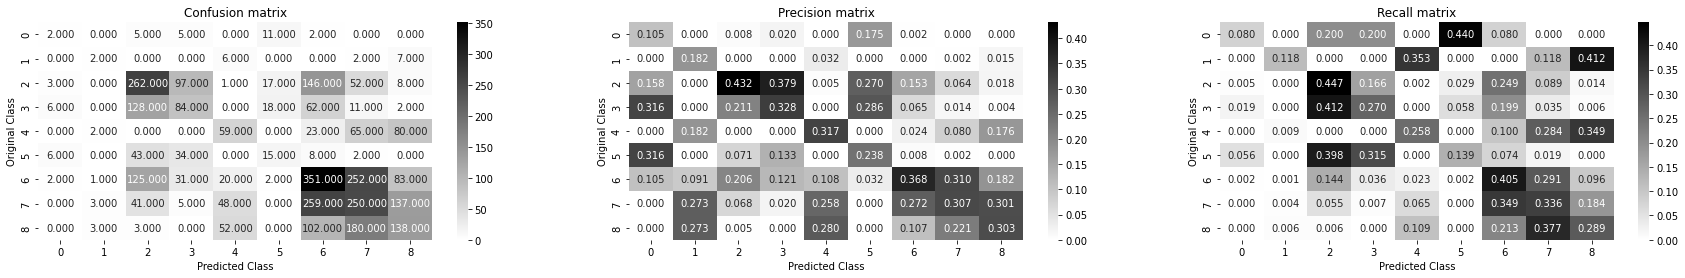

f1_score : 0.27019243457343056
log_loss : 1.7804974683942474


In [81]:
plot_confusion_matrix(y_test.values[:,1], lbgm_fs2_tar2['y_test_pred'],9)

print("f1_score :" ,lbgm_fs2_tar2['f1_score'])
print("log_loss :" ,lbgm_fs2_tar2['log_loss'])

In [82]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((lbgm_fs2_tar2['y_train_pred_proba'],lbgm_fs2_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((lbgm_fs2_tar2['y_test_pred_proba'],lbgm_fs2_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr2,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_2_test,proba2_test],axis=1)

In [83]:
# filename = 'Models/lbgm_fs2_tar2.pkl'
# joblib.dump(lbgm_fs2_tar2,open(filename,'wb'))

##### Feature Set-2 for predicting target_1

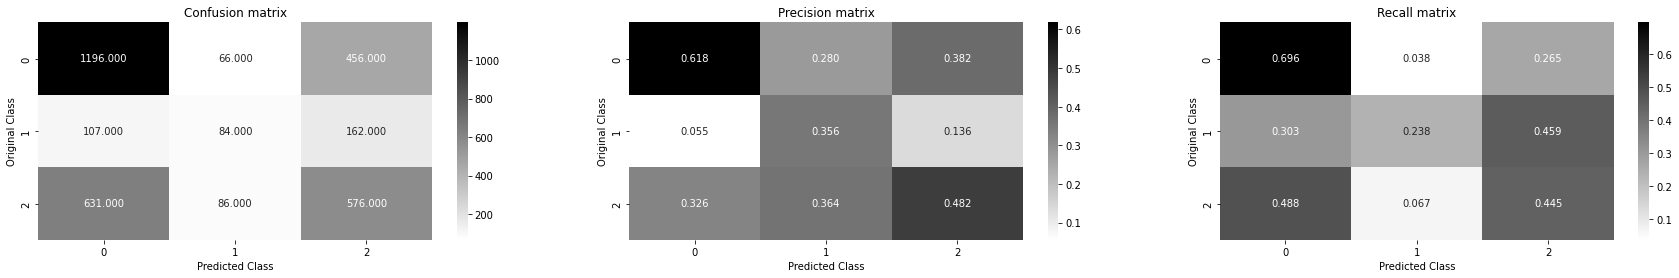

f1_score : 0.4678071526154732
log_loss : 2.0201087541420173


In [84]:
# lbgm_clf = lbg.LGBMClassifier(n_jobs=8)
# lbgm_fs2_tar1 = model(tar_1_X_train,label_FS2,tar_1_X_test,y_test.values[:,0],lbgm_clf,params,cv_type="random")
lbgm_fs2_tar1 = joblib.load('Models/lbgm_fs2_tar1.pkl','r+')

plot_confusion_matrix(y_test.values[:,0], lbgm_fs2_tar1['y_test_pred'],3)

print("f1_score :" ,lbgm_fs2_tar1['f1_score'])
print("log_loss :" ,lbgm_fs2_tar1['log_loss'])

In [85]:
# filename = 'Models/lbgm_fs2_tar1.pkl'
# joblib.dump(lbgm_fs2_tar1,open(filename,'wb'))

In [86]:
effective_f1score(lbgm_fs2_tar1['f1_score'],lbgm_fs2_tar2['f1_score'])

36.89997935944518

# CatBoost

In [87]:
params = {'iterations':[1000,2000,3000],'learning_rate':[0.0001, 0.001, 0.01, 0.1],'depth':[6,8,10]}

##### Feature Set-1 for predicting target_1

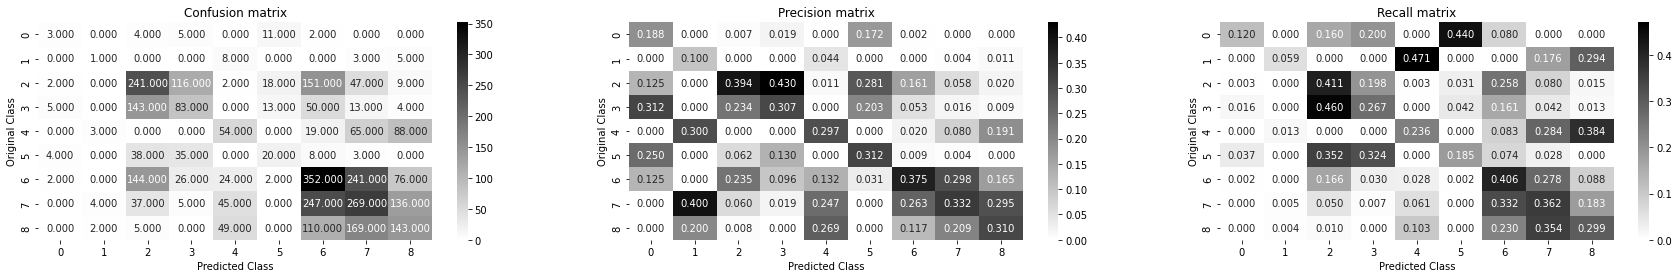

f1_score : 0.27162402935381424
log_loss : 1.7588206284640553


In [88]:
# cat_clf = CatBoostClassifier(task_type="GPU",metric_period=1000)
# cat_fs1_tar2 = model(X_tr1,y_tr1,FS_1_test,y_test.values[:,1],cat_clf,params,cv_type="random")
cat_fs1_tar2 = joblib.load('Models/cat_fs1_tar2.pkl','r+')

plot_confusion_matrix(y_test.values[:,1], cat_fs1_tar2['y_test_pred'],9)

print("f1_score :" ,cat_fs1_tar2['f1_score'])
print("log_loss :" ,cat_fs1_tar2['log_loss'])

In [89]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((cat_fs1_tar2['y_train_pred_proba'],cat_fs1_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((cat_fs1_tar2['y_test_pred_proba'],cat_fs1_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr1,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_1_test,proba2_test],axis=1)

In [90]:
# filename = 'Models/cat_fs1_tar2.pkl'
# joblib.dump(cat_fs1_tar2,open(filename,'wb'))

##### Feature Set-1 for predicting target_1

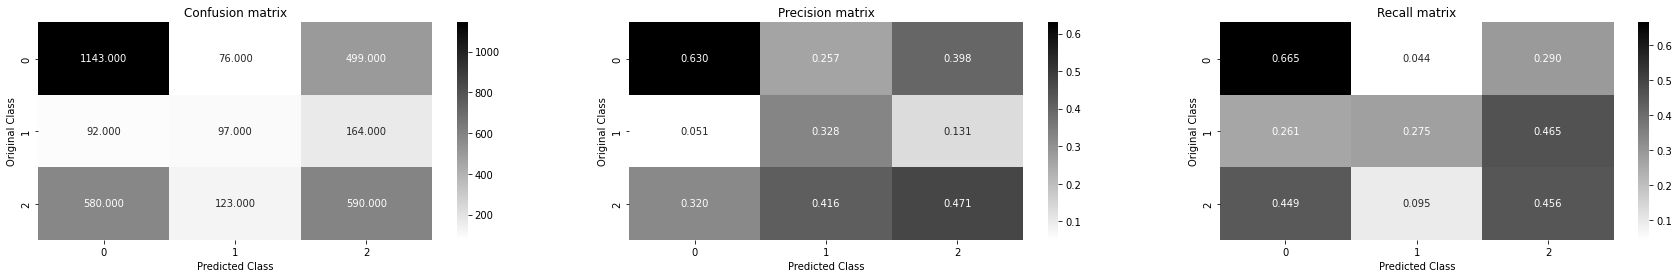

f1_score : 0.46981190149136104
log_loss : 3.4281895770624082


In [91]:
# cat_clf = CatBoostClassifier(task_type="GPU",metric_period=1000)
# cat_fs1_tar1 = model(tar_1_X_train,label_FS1,tar_1_X_test,y_test.values[:,0],cat_clf,params,cv_type="random")
cat_fs1_tar1 = joblib.load('Models/cat_fs1_tar1.pkl','r+')

plot_confusion_matrix(y_test.values[:,0], cat_fs1_tar1['y_test_pred'],3)

print("f1_score :" ,cat_fs1_tar1['f1_score'])
print("log_loss :" ,cat_fs1_tar1['log_loss'])

In [92]:
# filename = 'Models/cat_fs1_tar1.pkl'
# joblib.dump(cat_fs1_tar1,open(filename,'wb'))

In [93]:
effective_f1score(cat_fs1_tar1['f1_score'],cat_fs1_tar2['f1_score'])

37.07179654225877

##### Feature Set-2 for predicting target_2

In [94]:
# cat_clf = CatBoostClassifier(task_type="GPU",metric_period=1000)
# cat_fs2_taar2 = model(X_tr2,y_tr2,FS_2_test,y_test.values[:,1],cat_clf,params,cv_type="random")

cat_fs2_tar2 = joblib.load('Models/cat_fs2_tar2.pkl','r+')

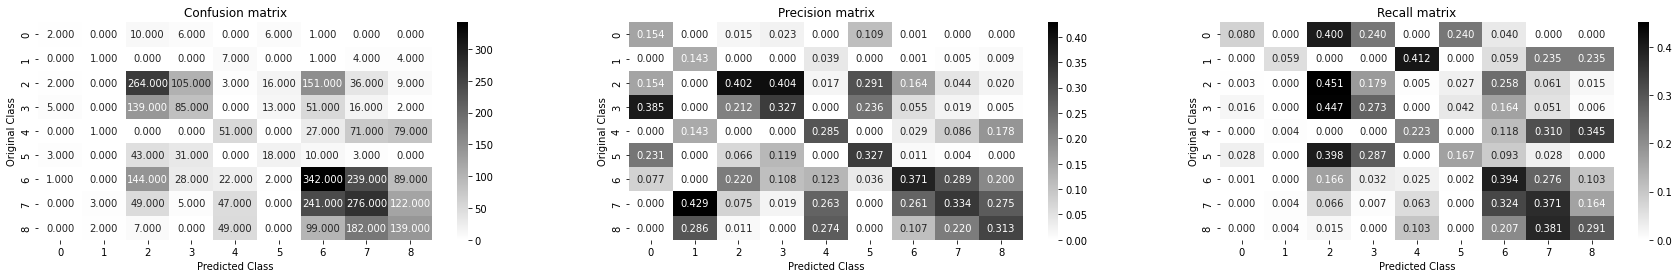

f1_score : 0.26861479469372324
log_loss : 1.7824791917080318


In [95]:
plot_confusion_matrix(y_test.values[:,1], cat_fs2_tar2['y_test_pred'],9)

print("f1_score :" ,cat_fs2_tar2['f1_score'])
print("log_loss :" ,cat_fs2_tar2['log_loss'])

In [96]:
cols_target2 = ['proba_class_'+str(i) for i in range(0,9)]+['target_2']

proba2_train = pd.DataFrame(np.concatenate((cat_fs2_tar2['y_train_pred_proba'],cat_fs2_tar2['y_train_pred'].reshape(-1,1)),axis=1),columns=cols_target2)
proba2_test = pd.DataFrame(np.concatenate((cat_fs2_tar2['y_test_pred_proba'],cat_fs2_tar2['y_test_pred'].reshape(-1,1)),axis=1),columns=cols_target2)

tar_1_X_train = pd.concat([X_tr2,proba2_train],axis=1)
tar_1_X_test = pd.concat([FS_2_test,proba2_test],axis=1)

In [97]:
# filename = 'Models/cat_fs2_tar2.pkl'
# joblib.dump(cat_fs2_tar2,open(filename,'wb'))

##### Feature Set-2 for predicting target_1

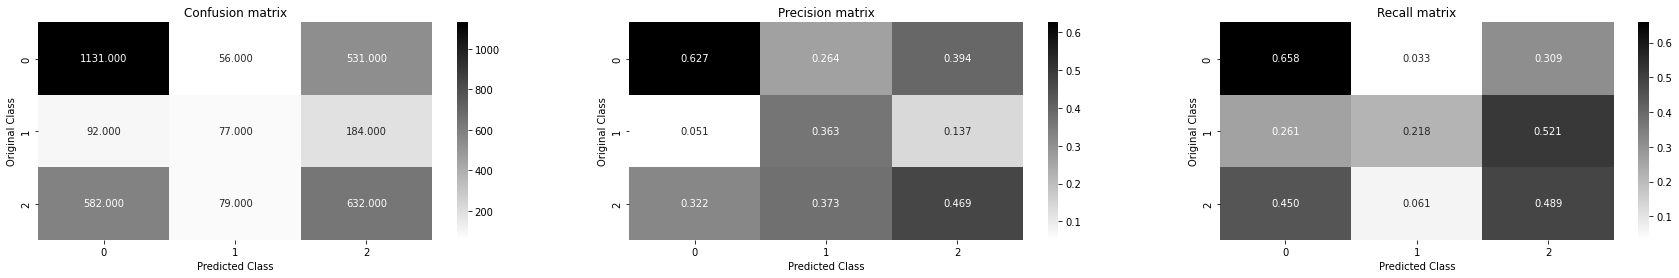

f1_score : 0.46447355704450044
log_loss : 2.5773749694810038


In [98]:
# cat_clf =CatBoostClassifier(task_type="GPU",metric_period=1000)
# cat_fs2_tar1 = model(tar_1_X_train,label_FS2,tar_1_X_test,y_test.values[:,0],cat_clf,params,cv_type="random")
cat_fs2_tar1 = joblib.load('Models/cat_fs2_tar1.pkl','r+')

plot_confusion_matrix(y_test.values[:,0], cat_fs2_tar1['y_test_pred'],3)

print("f1_score :" ,cat_fs2_tar1['f1_score'])
print("log_loss :" ,cat_fs2_tar1['log_loss'])

In [99]:
# filename = 'Models/cat_fs2_tar1.pkl'
# joblib.dump(cat_fs2_tar1,open(filename,'wb'))

In [100]:
effective_f1score(cat_fs2_tar1['f1_score'],cat_fs2_tar2['f1_score'])

36.65441758691119

# Comparing f1_scores and log loss for different models

In [101]:
from prettytable import PrettyTable

In [102]:
x_fetureset1 = PrettyTable()
x_fetureset1.field_names = ["Model", "f1 score target-1", "log loss target-1","f1 score target-2", "log loss target-2",'effective f1_score']

In [103]:
x_fetureset1.add_row(["Logistic Regression", LR_fs1_tar1['f1_score'],  LR_fs1_tar1['log_loss'],LR_fs1_tar2['f1_score'],  LR_fs1_tar2['log_loss'],effective_f1score(LR_fs1_tar1['f1_score'],LR_fs1_tar2['f1_score'])])

x_fetureset1.add_row(["RBF SVM",svm_fs1_tar1['f1_score'],svm_fs1_tar1['log_loss'],svm_fs1_tar2['f1_score'],svm_fs1_tar2['log_loss'],effective_f1score(svm_fs1_tar1['f1_score'],svm_fs1_tar2['f1_score'])])

x_fetureset1.add_row(["Random Forest",rf_fs1_tar1['f1_score'],rf_fs1_tar1['log_loss'],rf_fs1_tar2['f1_score'],rf_fs1_tar2['log_loss'],effective_f1score(rf_fs1_tar1['f1_score'],rf_fs1_tar2['f1_score'])])

x_fetureset1.add_row(["Light GBM",lbgm_fs1_tar1['f1_score'],lbgm_fs1_tar1['log_loss'],lbgm_fs1_tar2['f1_score'],lbgm_fs1_tar2['log_loss'],effective_f1score(lbgm_fs1_tar1['f1_score'],lbgm_fs1_tar2['f1_score'])])

x_fetureset1.add_row(["Cat Boost",cat_fs1_tar1['f1_score'],cat_fs1_tar1['log_loss'],cat_fs1_tar2['f1_score'],cat_fs1_tar2['log_loss'],effective_f1score(cat_fs1_tar1['f1_score'],cat_fs1_tar2['f1_score'])])


In [104]:
x_fetureset2 = PrettyTable()
x_fetureset2.field_names = ["Model", "f1 score target-1", "log loss target-1","f1 score target-2", "log loss target-2",'effective f1_score']

x_fetureset2.add_row(["Logistic Regression", LR_fs2_tar1['f1_score'],  LR_fs2_tar1['log_loss'],LR_fs2_tar2['f1_score'],  LR_fs2_tar2['log_loss'],effective_f1score(LR_fs2_tar1['f1_score'],LR_fs2_tar2['f1_score'])])

x_fetureset2.add_row(["RBF SVM",svm_fs2_tar1['f1_score'],svm_fs2_tar1['log_loss'],svm_fs2_tar2['f1_score'],svm_fs2_tar2['log_loss'],effective_f1score(svm_fs2_tar1['f1_score'],svm_fs2_tar2['f1_score'])])

x_fetureset2.add_row(["Random Forest",rf_fs2_tar1['f1_score'],rf_fs2_tar1['log_loss'],rf_fs2_tar2['f1_score'],rf_fs2_tar2['log_loss'],effective_f1score(rf_fs2_tar1['f1_score'],rf_fs2_tar2['f1_score'])])

x_fetureset2.add_row(["Light GBM",lbgm_fs2_tar1['f1_score'],lbgm_fs2_tar1['log_loss'],lbgm_fs2_tar2['f1_score'],lbgm_fs2_tar2['log_loss'],effective_f1score(lbgm_fs2_tar1['f1_score'],lbgm_fs2_tar2['f1_score'])])

x_fetureset2.add_row(["Cat Boost",cat_fs2_tar1['f1_score'],cat_fs2_tar1['log_loss'],cat_fs2_tar2['f1_score'],cat_fs2_tar2['log_loss'],effective_f1score(cat_fs2_tar1['f1_score'],cat_fs2_tar2['f1_score'])])

In [105]:
x_fetureset1

Model,f1 score target-1,log loss target-1,f1 score target-2,log loss target-2,effective f1_score
Logistic Regression,0.498316360932994,0.9287242759229433,0.2875523346451197,1.5467993973128242,39.293434778905684
RBF SVM,0.4586757449341687,1.0371195242405382,0.2896658033509479,1.5899353999988852,37.41707741425583
Random Forest,0.46748484246751426,1.5570730397742654,0.2912418491025264,1.5420811720180452,37.93633457850203
Light GBM,0.46079973869714747,2.1779389471378385,0.270308873466899,1.7823655360828612,36.55543060820233
Cat Boost,0.46981190149136104,3.4281895770624082,0.27162402935381424,1.7588206284640553,37.07179654225877


In [106]:
x_fetureset2

Model,f1 score target-1,log loss target-1,f1 score target-2,log loss target-2,effective f1_score
Logistic Regression,0.49701619658390594,0.9281171469707881,0.2821210359406281,1.5375659852663768,38.956861626226704
RBF SVM,0.4797094858302178,0.9111661541860465,0.29235018635316834,1.526703719482404,38.60298360916931
Random Forest,0.47335760275155686,1.5509585891390523,0.275868237982473,1.5421805015870924,37.461292036701494
Light GBM,0.4678071526154732,2.0201087541420173,0.27019243457343056,1.7804974683942474,36.89997935944518
Cat Boost,0.46447355704450044,2.5773749694810038,0.26861479469372324,1.7824791917080318,36.65441758691119


* RBF SVM on **featureset2** have highest f1_score to predict target-2
* Logistic Regression on **featureset1** have highest f1_score to predict target_1
* Logistic Regression on **featureset1** for predicting target-1 and target-2 have highest effective f1_score